<a href="https://colab.research.google.com/github/NoahLee99/ML-DL-studylog/blob/main/Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 어텐션을 사용한 신경망

* 기존의 RNN에는 기울기 소실이라는 큰 문제점이 존재한다.

* 쉽게 말해, 문맥의 양이 너무 많아져 마지막 셀(노드)까지 기존의 의미들이 전달되지 못하는 것이다.

* 맨 마지막 셀이 이 값을 디코더에 전달하는데,
<br> 이 마지막 셀에 담긴 값에 전체 문장의 뜻이 함축되어 있으므로 이를 **문맥 벡터(context vector)**라고 한다.

* 이러한 문제를 해결하기 위해 **어텐션(attention)** 방법이 등장했다.

* 어텐션은 기존 인코더-디코더 모델에 어텐션 층을 추가하여 성능을 향상시키는 방법이다.
<br> 어텐션 층은 입력 문장의 각 토큰에 대한 어텐션 스코어를 계산하여, 디코더가 출력 문장을 생성할 때 어떤 토큰에 더 집중해야 할지 알려준다.

* 더 자세히 설명하면, 어텐션 층은 입력 문장의 각 토큰과 출력 문장의 각 토큰 사이의 연관성을 계산해 어텐션 스코어를 얻는다. <br> 그리고 이 스코어를 소프트맥스 함수를 통해 0과 1 사이의 값을 갖는 어텐션 가중치로 변환한다.

* 디코더는 이 어텐션 가중치를 이용하여 입력 문장의 각 토큰에 대한 중요도를 고려하여 출력 문장을 생성한다.
<br> 즉, 어텐션 가중치가 높은 토큰에 더 집중하여 출력 문장을 생성하는 것이다.

* EX. "Attention is all you need!" --> "당신이 필요한 전부는 어텐션 이다!"
<br> 여기서 출력 문장의 "당신이"라는 토큰은 [0 0 0 1 0](예시)와 같은 가중치를 가질 것이다. (입력 문장 토큰의 위치에 따른 중요도)

* 이제 직접 어텐션 메커니즘을 사용해 IMDB 영화 리뷰를 분류해 보자.

In [1]:
# 필요 라이브러리 가동
!pip install -U keras-self-attention

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from keras_self_attention import SeqSelfAttention

import numpy as np
import matplotlib.pyplot as plt

# 데이터 로드 후 훈련 세트와 테스트 세트로 분할
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

# 리뷰당 단어 수 동일화(전처리)
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=022b958a043289a93edda7613d0f05b9f7b8cb53e3090d7298a5037c0c1ff7dd
  Stored in directory: /root/.cache/pip/wheels/46/f9/96/709295c836133071c12a300729fed4027757f889c01695feea
Successfully built keras-self-attention
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [2]:
# 모델 생성
model = Sequential()
model.add(Embedding(5000, 500))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True)) # 다음 레이어가 시퀀스 데이터를 입력 받을 수 있도록 함
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1))
model.add(Activation('sigmoid'))

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

# 학습 조기 종료 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# 모델 학습 실행
history = model.fit(X_train, y_train, batch_size=40, epochs=100,
                    validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

# 테스트 정확도 출력
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 124s 185ms/step - accuracy: 0.7181 - loss: 0.4955 - val_accuracy: 0.8964 - val_loss: 0.2538
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 115s 185ms/step - accuracy: 0.9216 - loss: 0.1994 - val_accuracy: 0.8930 - val_loss: 0.2631
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 186ms/step - accuracy: 0.9480 - loss: 0.1453 - val_accuracy: 0.8903 - val_loss: 0.2805
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 116s 186ms/step - accuracy: 0.9661 - loss: 0.0978 - val_accuracy: 0.8848 - val_loss: 0.3628
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.8852 - loss: 0.3620

 Test Accuracy: 0.8848


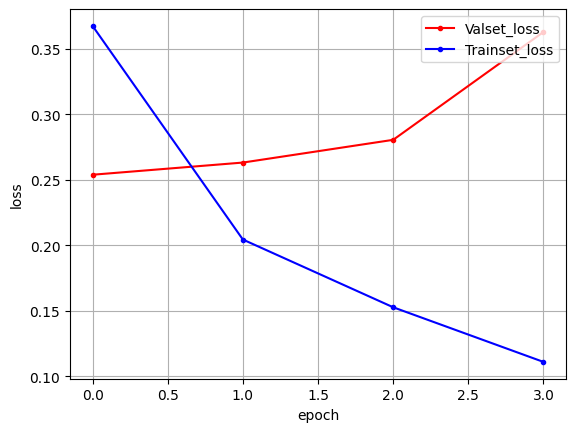

In [5]:
# 손실 그래프 시각화

# 검증 세트와 학습 세트의 손실 저장
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프 생성
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Valset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프 설정
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# 테스트 결과 정확도 약 89%로 이전의 LSTM 및 CNN 모델 보다 1%의 향상이 일어남!